In [1]:
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [99]:
from matplotlib.pyplot import imread
from ffht import fht
from numpy.lib.scimath import sqrt as csqrt

In [3]:
seed(42)
n = 300
d = n
x = rand(d)
A = rand(n, d)
b = np.abs(A.dot(x))

In [4]:
def f(w, x, nu):
    return np.abs(w - b).sum() + 1/(2*nu)*norm(A.dot(x) - w)**2

def grad_g(w, nu):
    x_star = lstsq(A, w, rcond=None)[0]
    return 1/nu*(w - A.dot(x_star))

def prox_h(z, nu):
    y = ((abs(z) - b - nu).clip(0, None) - (-abs(z) + b - nu).clip(0, None) + b)
    return y*sign(z)

def pgd(f, grad, prox, w0, nu = 1, maxIter=1000, tol=1e-3):
    log = {"func_val_x" : [], "func_val_w" : []}
    w = w0
    w_prev = inf
    k = 0
    while (norm(w_prev-w) > tol) and k < maxIter:
        x = lstsq(A, w, rcond=None)[0]
        log["func_val_x"].append(f(w, x, nu))
        w_prev = w
        w = prox(A.dot(x), nu)
        log["func_val_w"].append(f(w, x, nu))
        k += 1
    return w, log

## Dummy test

In [5]:
w_star, log = pgd(f, grad_g, prox_h, A.dot(x + 0.1*rand(d)), nu=0.5, maxIter=40)

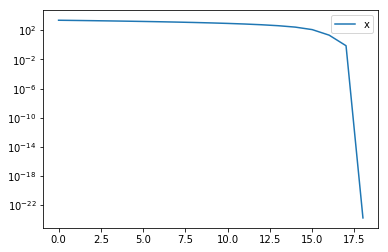

In [6]:
semilogy(log["func_val_x"], label="x")
legend()

## Real Grayscale Images 

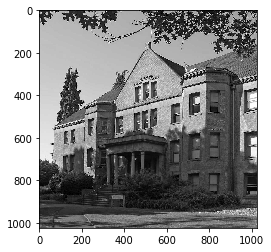

In [7]:
lewis = imread("lewis_grayscale.jpg")[:,:, 0]
imshow(lewis)
gray()

In [8]:
m, n = lewis.shape
lewis = lewis.reshape(m*n)

In [9]:
def corrupt(data, p=0.1):
    noise = rand(len(data)) > p
    return data * noise

In [16]:
corrupted_lewis = corrupt(lewis, p=0.95)

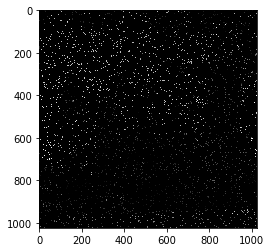

In [17]:
imshow(corrupted_lewis.reshape((m, n)))
gray()

In [18]:
def pad_to_power_of_two(arr, const=0):
    nextPower = np.ceil(np.log2((len(arr))))
    deficit = int(np.power(2, nextPower) - len(arr))
    return pad(arr, ((0, deficit)), 'constant'), deficit

#x, tail = pad_to_power_of_two(corrupted_lewis)

k = 4
seed(42)
S = rand(k, len(lewis))
S = (S > 0.5)*2-1

def Adot(x, k = k, S = S):
    m = len(x)
    result = zeros(k*m)
    for i, s in enumerate(S):
        result[i*m:i*m+m] = (s*x).astype(np.float32)
        fht(result[i*m:i*m+m])
    return result/sqrt(k*m)

def ATdot(w, k=k, S = S):
    result = zeros(int(len(w)/k))
    m = len(result)
    for i, s in enumerate(S):
        t = w[i*m:i*m+m]
        fht(t)
        result += s*t
    return result/sqrt(k*m)


b = np.abs(Adot(lewis))
w_star = Adot(lewis)
# D = zeros(k*len(x))
# D[:len(x)] = S[0]*S[1] + S[0]*S[2] + S[0]*S[3]
# D[len(x):2*len(x)] = S[1]*S[0] + S[1]*S[2] + S[1]*S[3]
# D[2*len(x):3*len(x)] = S[2]*S[0] + S[2]*S[1] + S[2]*S[3]
# D[3*len(x):] = S[3]*S[0] + S[3]*S[1] + S[3]*S[2]

In [19]:
def f(w, x, nu):
    return np.abs((np.abs(w) - b)).sum() + 1/(2*nu)*norm(Adot(x, k = k, S = S) - w)**2

def prox_h(z, nu):
    y = ((abs(z) - b - nu).clip(0, None) - (-abs(z) + b - nu).clip(0, None) + b)
    return y*sign(z)

def pgd(f, prox, w0, nu = 1, maxIter=2000, tol=1e-3):
    log = {"func_val" : [], "opt_cond" : []}
    w = w0
    c = 0
    iter_num = 0
    x = 0
    x_prev = 30
    w_prev = 30
    while (norm(x_prev-x) > tol) and iter_num < maxIter:
        x_prev = x
        x = ATdot(w, k = k, S = S)
        w = prox(Adot(x, k = k, S = S), nu)
        log["opt_cond"].append(norm(x_prev - x))
        f_val = f(w, x, nu)
        log["func_val"].append(f_val)
        iter_num += 1
    return w, log

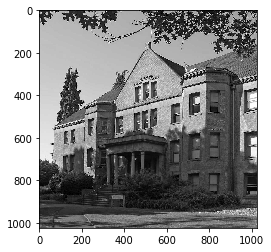

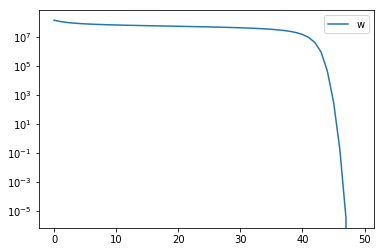

In [20]:
x0 = corrupted_lewis
w0 = Adot(x0)
nu = 20
f_min = f(w_star, lewis, nu)
w_pred, log = pgd(f, prox_h, w0 = w0, nu = nu, tol=1e-3)
x_pred = ATdot(w_pred).reshape((m, n))
imshow(x_pred)
show()
semilogy(array(log["func_val"]), label="w")
legend()

[]

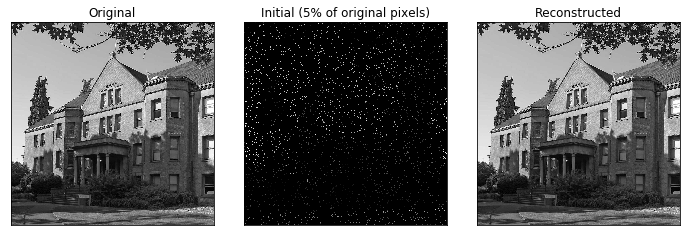

In [22]:
fig = figure(figsize=(12,4))
grid = plt.GridSpec(1, 3, wspace=0.15, hspace=0.15)
orig = fig.add_subplot(grid[0, 0])
orig.imshow(lewis.reshape((m,n)))
orig.set_title("Original")
orig.set_xticks([])
orig.set_yticks([])
corrupted = fig.add_subplot(grid[0, 1])
corrupted.imshow(corrupted_lewis.reshape((m,n)))
corrupted.set_title("Initial (5% of original pixels)")
corrupted.set_xticks([])
corrupted.set_yticks([])
reconstructed = fig.add_subplot(grid[0, 2])
reconstructed.imshow(x_pred)
reconstructed.set_title("Reconstructed")
reconstructed.set_xticks([])
reconstructed.set_yticks([])

## Real Color Image

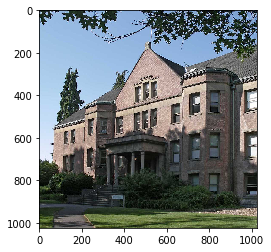

In [86]:
lewis = imread("lewis.jpeg")
imshow(lewis)
gray()

In [87]:
m, n, d = lewis.shape
lewis = lewis.reshape(m*n*d)

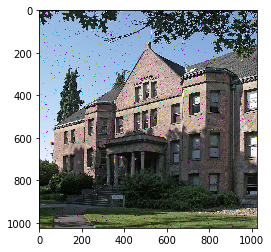

In [88]:
corrupted_lewis = corrupt(lewis, p=0.01)
imshow(corrupted_lewis.reshape((m, n, d)))

In [93]:
def pad_to_power_of_two(arr, const=0):
    nextPower = np.ceil(np.log2((len(arr))))
    deficit = int(np.power(2, nextPower) - len(arr))
    return pad(arr, ((0, deficit)), 'reflect'), deficit

corrupted_lewis_ext, tail = pad_to_power_of_two(corrupted_lewis)
lewis_ext, tail = pad_to_power_of_two(lewis)

seed(42)
k = 4
S = rand(k, len(corrupted_lewis_ext))
S = (S > 0.5)*2-1
b = np.abs(Adot(corrupted_lewis_ext, k = k, S = S))
w0 = Adot(corrupted_lewis_ext, k = k, S = S)
nu = 0.5
w_star = Adot(lewis_ext, k = k, S = S)
#f_min = f(w_star, lewis_ext, nu)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


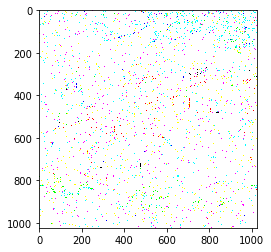

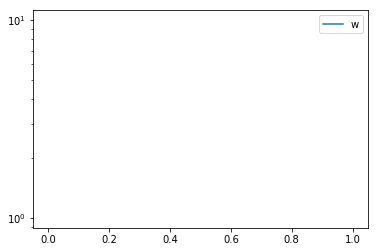

In [95]:
w_pred, log = pgd(f, grad_g, prox_h, w0 = w0, nu = nu, tol=1e-3)
x_pred = (ATdot(w_pred, k = k, S = S)[:-tail]).reshape((m, n, d))
imshow(x_pred)
show()
semilogy(array(log["func_val"]), label="w")
legend()

## Semi-quadratic loss

In [128]:
lewis = imread("lewis_grayscale_128.jpg")[:,:, 0]
m, n = lewis.shape
lewis = lewis.reshape(m*n)
corrupted_lewis = corrupt(lewis, p=0.1)

k = 4
seed(42)
S = rand(k, len(lewis))
S = (S > 0.5)*2-1

def Adot(x, k = k, S = S):
    m = len(x)
    result = zeros(k*m)
    for i, s in enumerate(S):
        result[i*m:i*m+m] = (s*x).astype(np.float32)
        fht(result[i*m:i*m+m])
    return result/sqrt(k*m)

def ATdot(w, k=k, S = S):
    result = zeros(int(len(w)/k))
    m = len(result)
    for i, s in enumerate(S):
        t = w[i*m:i*m+m]
        fht(t)
        result += s*t
    return result/sqrt(k*m)


b = np.abs(Adot(lewis))
w_star = Adot(lewis)
xs_trajectory = []
f_vals = []


def f(w, x, z, nu, lam):
    A = np.abs((np.abs(z) - b**2)).sum()
    B = 1/(2*nu)*norm(Adot(x, k = k, S = S) - w)**2
    C = 1/(2*lam)*norm(w**2 - z)**2
    print(A, B, C, A+B+C)
    return np.abs((np.abs(z) - b**2)).sum() + 1/(2*nu)*norm(Adot(x, k = k, S = S) - w)**2 + 1/(2*lam)*norm(w**2 - z)**2

def prox_h(z, nu):
    y = ((abs(z) - b**2 - nu).clip(0, None) - (-abs(z) + b**2 - nu).clip(0, None) + b**2)
    return y*sign(z)

def prox_phi(z, x, nu, lam, y=None):
    w = zeros(len(z))
    y = Adot(x)
    for i, (zi, yi) in enumerate(zip(z, y)):
        c = np.poly1d([1/(2*lam),0,- (zi/lam - 1/(2*nu)),- yi/nu,(zi**2/(2*lam) + (yi)**2/(2*nu))])
        d = np.poly1d([1, 0, -(zi - lam/(2*nu)), -lam*yi/(2*nu)])
        d2 = np.poly1d([3, 0, -(zi - lam/(2*nu))])
        crit = d.r
        r_crit = crit[crit.imag==0].real
        test = d2(r_crit) 
        x_min = r_crit[test>0]
        w[i] = x_min[argmin(c(x_min))]
        
#         v = zi - lam/(2*nu)
#         u = lam*yi/(2*nu)
#         w_alt = (2./3.)**(1./3.)*v/(sqrt(3)*sqrt(27*u**2 - 4*v**3) + 9*u)**(1./3.) + (sqrt(3)*sqrt(27*u**2 - 4*v**3) + 9*u)**(1./3.)/((2)**(1./3.)*3**(2./3.))
#         w[i] = w_alt
#        if i % 100000 == 0:
#            print(i)
        
#        plot(w[i], c(w[i]), 'o')
#        t_span = linspace(-2, 2, 100)
#        plot(t_span, c(t_span))
#        show()
#     v = z - lam/(2*nu)
#     u = lam*y/(2*nu)
#     w_alt = (2./3.)**(1./3.)*v/(sqrt(3)*csqrt(27*u**2 - 4*v**3) + 9*u)**(1./3.) + (sqrt(3)*csqrt(27*u**2 - 4*v**3) + 9*u)**(1./3.)/((2)**(1./3.)*3**(2./3.))
#     w = w_alt
    return w

def pgd2(w0, nu = 1, lam=1, maxIter=2000, tol=1e-3):
    log = {"func_val" : [], "opt_cond" : []}
    w = w0
    z = w0**2
    c = 0
    iter_num = 0
    x = 60
    x_prev = 30
    #w_prev = 30
    #z_prev = 30
    
    while iter_num < maxIter and (norm(x_prev-x) > tol) or iter_num < 3:
        print(iter_num)
        x_prev = x
        x = ATdot(w, k = k, S = S)
        w = prox_phi(z, x, nu, lam)
        z = prox_h(w**2, lam)
        log["opt_cond"].append(norm(x_prev - x))
        f_val = f(w, x, z, nu, lam)
        log["func_val"].append(f_val)
        f_vals.append(f_val)
        iter_num += 1
        xs_trajectory.append(x)
        #print(f_val)
    return w, log

In [ ]:
x0 = corrupted_lewis
w0 = Adot(x0)
z0 = w0**2
nu = 20
lam = 20
w_pred, log = pgd2(w0, lam = lam, nu = nu, maxIter=2000, tol=1e-6)
x_pred =  ATdot(w_pred).reshape((m, n))
imshow(x_pred)
show()
semilogy(array(log["func_val"]), label="w")
legend()

0
102203445.28083801 3.8841131564410807e-25 640913.2874926922 102844358.5683307
1
100951240.86716732 1123.312574263296 624382.5396424182 101576746.71938401
2
99728528.85383283 2294.239034844596 609955.2262570475 100340778.31912471
3
98532060.97823139 3819.2671689601457 597043.568344585 99132923.81374492
4
97360135.52735089 5505.701693170802 585126.1998935699 97950767.42893763
5
96210116.5605021 7289.724037501852 574230.4908125286 96791636.77535212
6
95081309.18575847 9162.436958930219 563810.675794082 95654282.29851148
7
93972995.46269946 11086.24125697274 553595.6183832338 94537677.32233965
8
92883987.78045875 13019.694454332135 544053.3735796858 93441060.84849276
9
91813582.62639554 14957.42456378548 534763.6027545301 92363303.65371385
10
90761068.0079557 16879.64881172558 525949.9010377984 91303897.55780523
11
89725777.61076954 18779.530098525396 517348.4351280867 90261905.57599616
12
88707306.84608829 20665.699743653313 508964.78418038966 89236937.33001234
13
87705386.3726098 22505

33313923.9079175 42966.247257716735 159901.85853279315 33516792.01370801
109
32996619.89324284 42209.99991136714 158398.67033128615 33197228.563485492
110
32682794.635119285 41535.867053613045 156616.8143154253 32880947.316488326
111
32372549.03861091 40938.236359487724 154849.77512475927 32568337.050095156
112
32065530.425171968 40391.97145592442 153218.90512021128 32259141.301748104
113
31762035.32820602 39829.74430661058 151470.27953822265 31953335.352050852
114
31461631.73650184 39395.273414992844 149934.29084882347 31650961.300765656
115
31164373.987782005 38923.66743688414 148372.1298105927 31351669.785029482
116
30869975.634520173 38483.89558276437 146908.2770901577 31055367.807193097
117
30578604.193663396 37991.09497519019 145436.50694108644 30762031.79557967
118
30290115.049970124 37457.68106939768 143976.65571378928 30471549.38675331
119
30004691.046989094 37067.702332328234 142430.1602223793 30184188.9095438
120
29722451.626234926 36650.61059558674 140810.16257451463 298999

12718817.816555813 14729.232798684849 56405.127600760585 12789952.176955258
214
12606754.944307206 14583.179641731082 55891.50601175198 12677229.62996069
215
12495958.863617359 14448.003755825885 55251.42919479576 12565658.29656798
216
12386145.98590159 14312.15185764441 54783.44566788338 12455241.583427118
217
12277255.645467538 14168.118074075212 54333.149384899756 12345756.912926512
218
12169217.728957517 14023.269870605021 53904.123161398296 12237145.12198952
219
12062137.146259965 13885.127168083334 53407.73682487387 12129430.010252923
220
11956000.578544656 13748.985421547732 52946.81141103376 12022696.375377238
221
11850826.691858858 13617.093010714514 52457.7134962331 11916901.498365805
222
11746612.61984235 13485.652902463204 51995.1526069639 11812093.425351778
223
11643430.421904948 13351.395125150137 51428.78319034568 11708210.600220444
224
11541618.519894179 13215.858601207256 50751.82045852521 11605586.198953912
225
11441102.977880893 13084.117778608845 50111.1622271572 11

5092129.673645753 5163.888680510083 21546.59285447241 5118840.155180736
321
5049415.284073735 5114.072919637982 21299.538779459122 5075828.8957728315
322
5007034.587387248 5064.561123782559 21154.300005208348 5033253.448516239
323
4965019.321443067 5015.6019253079385 20958.675816099374 4990993.599184474
324
4923421.54124572 4966.9681918984725 20755.111935770154 4949143.621373389
325
4882115.990611088 4918.46619893929 20608.65487728662 4907643.111687314
326
4841087.126181083 4870.288530594793 20472.0600451771 4866429.474756855
327
4800289.8457333585 4821.702332667912 20367.993102500805 4825479.541168528
328
4759709.249151085 4774.915879687068 20253.99092451272 4784738.155955285
329
4719619.077655564 4727.740208517303 19983.156328283876 4744329.974192366
330
4679967.874309131 4680.83039556449 19776.004131706737 4704424.708836402
331
4640787.955682784 4635.19396786155 19542.682409836714 4664965.832060482
332
4602009.391716113 4588.911573842276 19349.493938157542 4625947.797228113
333
4563

2069727.532332234 1828.9622464227887 8907.418463921187 2080463.9130425781
427
2052088.896216778 1811.1363842497428 8800.915036808254 2062700.947637836
428
2034624.8499083545 1793.6994358193945 8711.046119778663 2045129.5954639525
429
2017335.648846358 1776.574282769196 8626.141444522706 2027738.3645736498
430
2000149.369672344 1759.5194875430702 8579.078027495962 2010487.967187383
431
1983125.0402424796 1742.582399637143 8494.3899611801 1993362.012603297
432
1966208.9005576926 1725.9414159406635 8446.257491307671 1976381.0994649408
433
1949362.2524765916 1709.4996246641965 8405.39681639921 1959477.148917655
434
1932656.1243930939 1692.9780002299722 8342.628561248906 1942691.7309545728
435
1916072.0268694127 1676.8676459938579 8272.112420787218 1926021.0069361937
436
1899687.5054303946 1660.8617546003406 8177.352176203722 1909525.7193611986
437
1883442.9101132527 1644.9514421712568 8102.005706560705 1893189.8672619849
438
1867307.4372435913 1629.2919936105816 8062.100176330461 1876998.8

867372.4536319354 678.538438117242 3392.1813313478924 871443.1734014006
533
860619.8859195608 672.3955458762389 3371.673890353384 864663.9553557904
534
853922.4006854638 666.2789181313196 3338.528138081151 857927.2077416764
535
847312.6181220607 660.2531822586652 3295.9606050566094 851268.831909376
536
840759.3417543116 654.2828425453255 3268.2592586221435 844681.8838554791
537
834263.0793642813 648.3592464314654 3243.5871734751217 838155.0257841878
538
827803.806406236 642.4968731765073 3222.1194040242567 831668.4226834368
539
821388.758732633 636.6246017819637 3201.2401243025215 825226.6234587175
540
815042.9227532323 630.8651005301591 3165.952089618096 818839.7399433806
541
808749.6044791393 625.1643511505545 3138.6626429511343 812513.431473241
542
802537.0505649265 619.5136095154891 3095.3986153658584 806251.9627898078
543
796426.6030548933 613.9147938520833 3048.547209083643 800089.0650578291
544
790372.4507064426 608.3654568434036 3020.8098587575023 794001.6260220435
545
784346.9

372222.40957118466 262.31608556726906 1520.3666015859415 374005.0922583379
640
369187.6738076026 260.1233954263701 1514.3091502447498 370962.10635327373
641
366175.61458495 257.952525724444 1502.8145687152764 367936.3816793897
642
363189.9702973164 255.80358268822866 1490.6667063882835 364936.4405863929
643
360207.86250330426 253.67722474139705 1490.354450220052 361951.8941782657
644
357234.8848930467 251.57272778607648 1483.3166115254287 358969.7742323582
645
354286.1644516641 249.48981120609884 1471.4552871587894 356007.109550029
646
351371.00981193513 247.4277087425694 1451.7153149461578 353070.1528356238
647
348543.69739316154 245.3866064285142 1408.4637673585585 350197.54776694864
648
345741.68798885087 243.36148341575736 1400.3389299456362 347385.3884022123
649
342939.697877101 241.354632035044 1400.3361607009049 344581.388669837
650
340144.0183441207 239.3671099942556 1395.031640264665 341778.4170943796
651
337362.0665445528 237.39880304205383 1390.330707161701 338989.7960547565

0


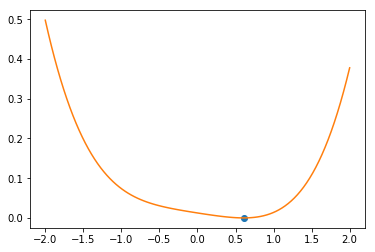

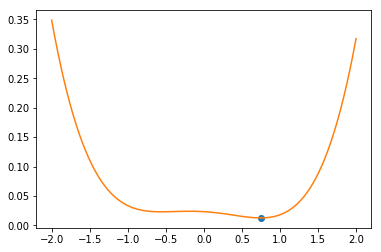

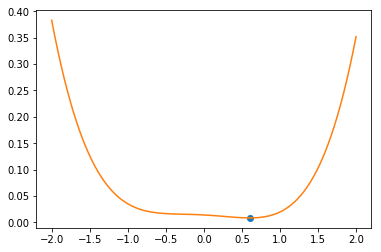

In [93]:
seed(42)
z = rand(3)
y = rand(3)
w = prox_phi(z, y, lam, nu)